## Experiment-0:  COCO - BG SUB - 0.1

Training params: 
    - Batch size: 64
    - Background subtraction: True
    - Background subtraction value: 0.1

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.coco import COCODataModule
import torch
from src.models.pixelcnn import PixelCNN
from src.models.coco_pixelcnn import COCOPixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc, test_ood_COCO

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)

1


42

In [4]:
cocodata_person = COCODataModule(foreground_data_dir='./data/COCO/foreground_images/person', 
                                 background_data_dir='./data/COCO/background_images/person', 
                                 convert_grayscale=True, 
                                 normalize=True)
cocodata_person.prepare_data()
cocodata_person.setup()

# cocodata_car = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/car', 
#                               background_data_dir='./data/COCO/background_images/car', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_dog = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/dog', 
#                               background_data_dir='./data/COCO/background_images/dog', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_teddy_bear = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/teddy bear', 
#                               background_data_dir='./data/COCO/background_images/teddy bear/', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_umbrella = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/umbrella', 
#                               background_data_dir='./data/COCO/background_images/umbrella', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_clock = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/clock', 
#                               background_data_dir='./data/COCO/background_images/clock', 
#                               convert_grayscale=True, 
#                               normalize=True)


# experiment_name = 'PixelCNNBgSub_01_COCO_1'

experiment_name = 'PixelCNN_COCO_1'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=3,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=20, gpus=1,logger=logger, 
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
model = COCOPixelCNN(background_subtraction=False, background_subtraction_value=0.0)


trainer.fit(model, cocodata_person)

/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 278 K 


In [5]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [9]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model_full_img = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path,  
                                                          background_subtraction=False,
                                                          background_subtraction_value=0.0).cuda()
eval_model_full_img.eval()

# eval_model_bg_subtraction = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=True, 
#                                                                        background_subtraction_value=0.1).cuda()

# eval_model = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=False, 
#                                                                        background_subtraction_value=0.0).cuda()

# eval_model_bg_subtraction.eval()
# eval_model.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): BatchNorm2d(64, e

## Evaluation with BG-Subtraction

In [8]:
targets, results = test_ood_COCO(trainer, eval_model_full_img, cocodata_person, cocodata_car)

Set SLURM handle signals.


/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.


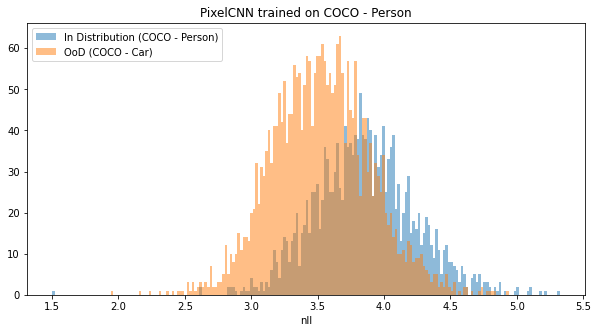

In [9]:
idd_losses = results[0:1750]
ood_losses = results[1751:4451]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Car)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

In [16]:
targets, results = test_ood_COCO(trainer, eval_model_bg_subtraction, cocodata_person, cocodata_clock)

Set SLURM handle signals.


Set SLURM handle signals.


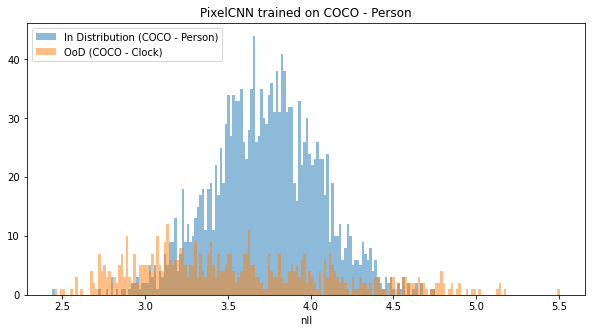

In [17]:
idd_losses = results[0:1750]
ood_losses = results[1751:2307]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Clock)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

In [18]:
targets, results = test_ood_COCO(trainer, eval_model_bg_subtraction, cocodata_person, cocodata_dog)

Set SLURM handle signals.


Set SLURM handle signals.


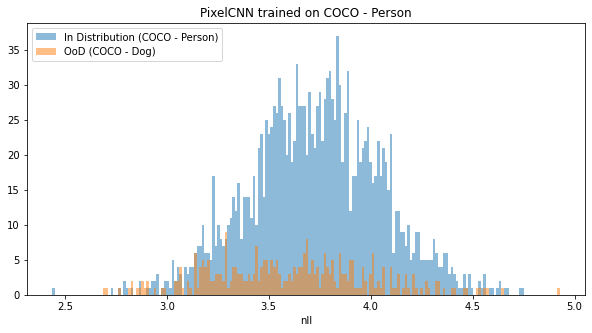

In [19]:
idd_losses = results[0:1750]
ood_losses = results[1751:2066]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Dog)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

In [22]:
targets, results = test_ood_COCO(trainer, eval_model_bg_subtraction, cocodata_person, cocodata_teddy_bear)

Set SLURM handle signals.


Set SLURM handle signals.


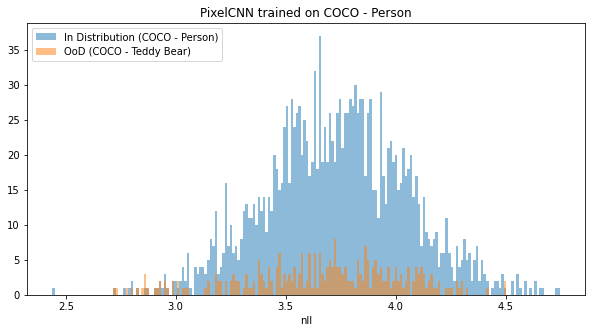

In [23]:
idd_losses = results[0:1750]
ood_losses = results[1751:2031]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Teddy Bear)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

In [24]:
targets, results = test_ood_COCO(trainer, eval_model_bg_subtraction, cocodata_person, cocodata_umbrella)

Set SLURM handle signals.


Set SLURM handle signals.


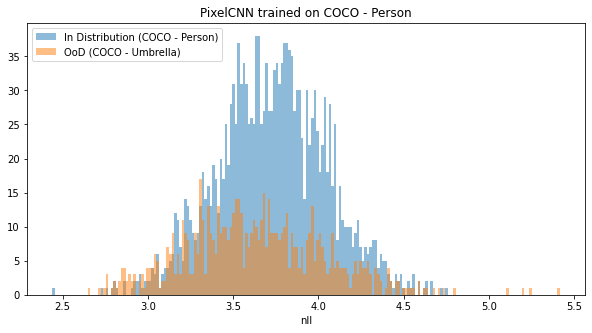

In [25]:
idd_losses = results[0:1750]
ood_losses = results[1751:2463]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Umbrella)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

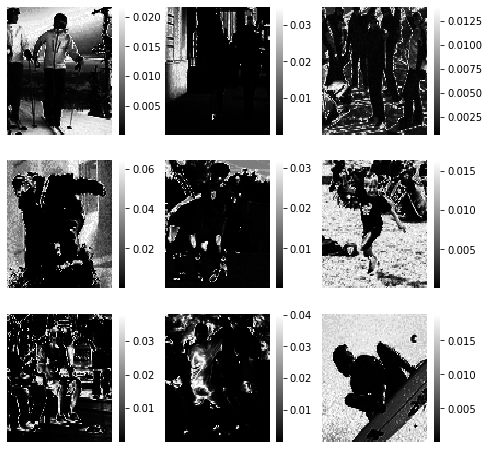

In [10]:
from src.utils.pixelcnn import generate_images, draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img)
# generate_images(eval_model_full_img, 96)

## Evaluation WO BG-Subtraction

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
                                                                       background_subtraction=False, 
                                                                       background_subtraction_value=0.0).cuda()

eval_model.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): BatchNorm2d(64, e

In [19]:
targets, results = test_ood_COCO(trainer, eval_model, cocodata_person, cocodata_car)

Set SLURM handle signals.


Set SLURM handle signals.


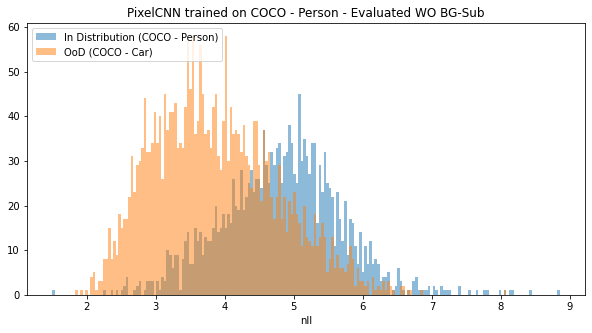

In [20]:
idd_losses = results[0:1750]
ood_losses = results[1751:4451]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Car)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - Evaluated WO BG-Sub')
plt.show()

In [11]:
targets, results = test_ood_COCO(trainer, eval_model, cocodata_person, cocodata_clock)

Set SLURM handle signals.


Set SLURM handle signals.


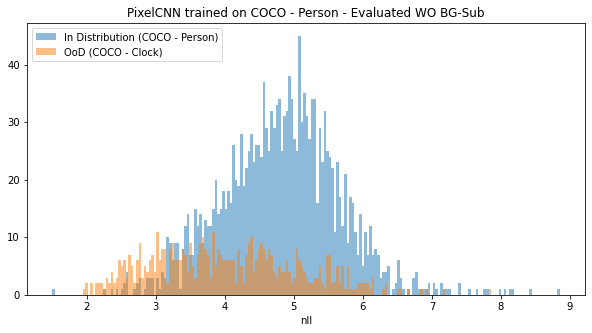

In [12]:
idd_losses = results[0:1750]
ood_losses = results[1751:2307]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Clock)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - Evaluated WO BG-Sub')
plt.show()

In [13]:
targets, results = test_ood_COCO(trainer, eval_model, cocodata_person, cocodata_dog)

Set SLURM handle signals.


Set SLURM handle signals.


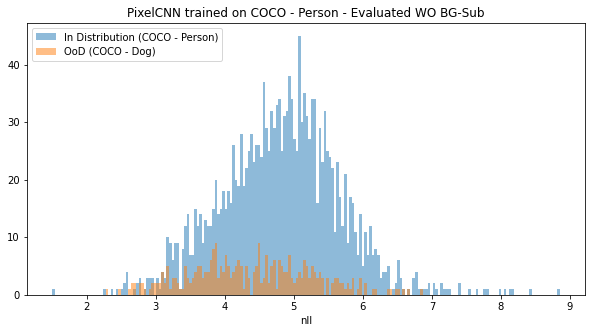

In [14]:
idd_losses = results[0:1750]
ood_losses = results[1751:2066]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Dog)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - Evaluated WO BG-Sub')
plt.show()

In [15]:
targets, results = test_ood_COCO(trainer, eval_model, cocodata_person, cocodata_teddy_bear)

Set SLURM handle signals.


Set SLURM handle signals.


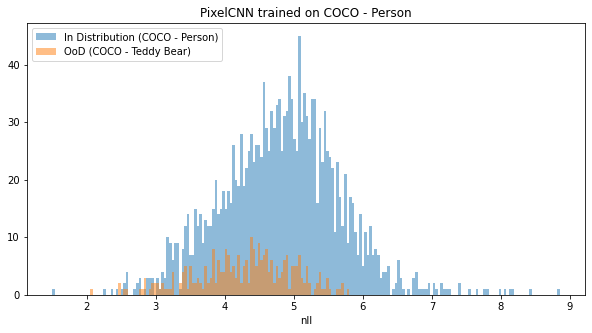

In [16]:
idd_losses = results[0:1750]
ood_losses = results[1751:2031]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Teddy Bear)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person')
plt.show()

In [17]:
targets, results = test_ood_COCO(trainer, eval_model, cocodata_person, cocodata_umbrella)

Set SLURM handle signals.


Set SLURM handle signals.


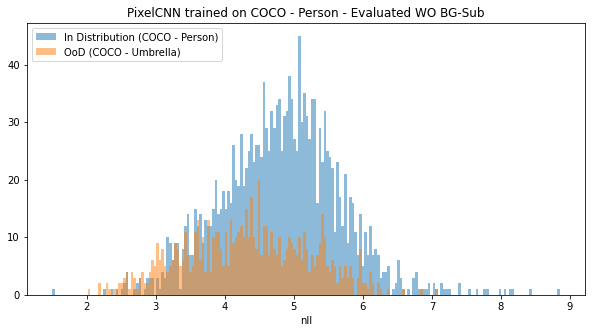

In [18]:
idd_losses = results[0:1750]
ood_losses = results[1751:2463]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Umbrella)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - Evaluated WO BG-Sub')
plt.show()